In [1]:
import sys
sys.path += ["../"]

import re
import smbh
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec

from mpl_toolkits.axes_grid1 import make_axes_locatable

COLOR_CYCLE = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
def plotEllipsoid(a_2, a_3):

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    m = 1

    # Make data.
    phi = np.linspace(0, 2 * np.pi)
    theta = np.linspace(0, np.pi)
    PHI, THETA = np.meshgrid(phi, theta)

    X = m * np.sin(THETA) * np.cos(PHI)
    Y = m * np.sin(THETA) * np.sin(PHI) * a_2
    Z = m * np.cos(THETA) * a_3

    min_ = X.min()
    max_ = X.max()

    # Plot the surface.

    # ax.view_init(30, 45)
    surf = ax.plot_wireframe(X, Y, Z, linewidth = 0.5)

    ax.contour(X, Y, Z, zdir='z', offset = min_)
    ax.contour(X, Y, Z, zdir='x', offset = min_)
    ax.contour(X, Y, Z, zdir='y', offset = max_)

    ax.set_xlim(min_, max_)
    ax.set_ylim(min_, max_)
    ax.set_zlim(min_, max_)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    fig.tight_layout()
    return fig, ax

In [3]:
AXIS = np.genfromtxt("axis.txt", skip_header = 1, delimiter = ', ')[:30]
SPEEDS = np.genfromtxt("initial.txt", skip_header = 1, delimiter = ', ')

# Axis

In [4]:
is_, a_1, a_2, a_3 = AXIS.T

In [5]:
A_2, A_3 = np.meshgrid(a_2, a_3)

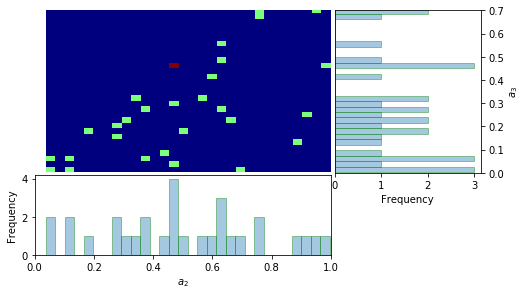

In [6]:
fig = plt.figure(figsize = (8, 4.5))

n_bins = 30
gs = GridSpec(3, 3)
gs.update(wspace = 0.025, hspace = 0.025) # set the spacing between axes. 

ax1 = plt.subplot(gs[:-1, :-1])
ax2 = plt.subplot(gs[-1, :-1])
ax3 = plt.subplot(gs[:-1, -1])

_ = ax1.hist2d(a_2, a_3, bins = n_bins, cmap = 'jet')

ax1.set_xlim(0, 1)
ax1.set_ylim(0, 0.7)

ax1.axis('off')

ax2.hist(a_2, bins = n_bins, edgecolor = 'g', alpha = 0.4)
ax2.set_xlim(0, 1)

ax3.hist(a_3, bins = n_bins, orientation = 'horizontal', edgecolor = 'g', alpha = 0.4)
ax3.set_ylim(0, 0.7)

ax3.set_ylabel('$a_3$')
ax2.set_xlabel('$a_2$')

ax2.set_ylabel('Frequency')
ax3.set_xlabel('Frequency')

ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")

fig.savefig('triaxial_axes.png', dpi = 300)

# Triaxiality parameter

In [7]:
T = (1 - (a_2 / a_1) ** 2) / (1 - (a_3 / a_1) ** 2)
pos = T.argsort()

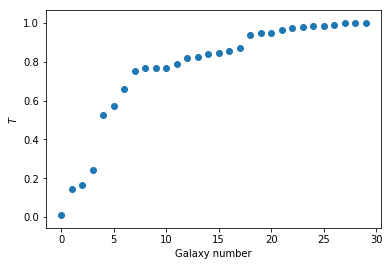

In [8]:
fig, ax = plt.subplots()
ax.scatter(np.arange(len(T)), T[pos])
ax.set_ylabel('$T$')
ax.set_xlabel('Galaxy number')

plt.show()

# Results

In [9]:
return_times = np.genfromtxt('return_times.txt')
return_masses = np.genfromtxt('return_masses.txt')
lyapunov = np.genfromtxt("lyapunov_exponents.txt")

# Speeds

In [10]:
def getR_Phi_Theta():
    global SPEEDS
    js_, rv_x, rv_y, rv_z = SPEEDS.T
    rv = (SPEEDS[:, 1:] ** 2).sum(axis = 1) ** 0.5
    phi = np.arctan2(rv_y, rv_x)
    theta = np.arccos(rv_z / rv)
    
    return rv, theta, phi

In [11]:
js_, rv_x, rv_y, rv_z = SPEEDS.T

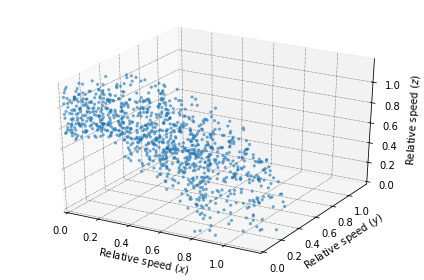

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(rv_x, rv_y, rv_z, alpha = 0.5, s = 5)

ax.set_xlim(0, 1.2)
ax.set_ylim(0, 1.2)
ax.set_zlim(0, 1.2)

ax.set_xlabel("Relative speed ($x$)")
ax.set_ylabel("Relative speed ($y$)")
ax.set_zlabel("Relative speed ($z$)")

fig.tight_layout()

fig.savefig("3d_initial_speeds.png", dpi = 300)

plt.show()

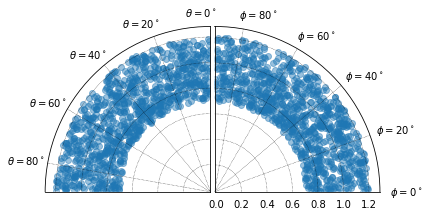

In [13]:
rv, theta, phi = getR_Phi_Theta()
fig, (ax1, ax2) = smbh.makePolarPlot(rv, theta, phi)

fig.savefig("polar_initial_speeds.png", dpi = 300)
plt.show()

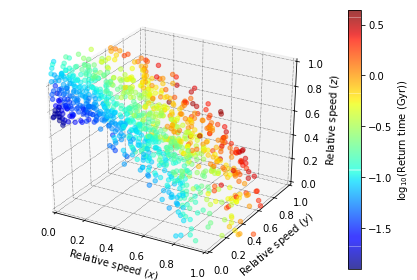

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

c = np.log10(return_times[3])

sc = ax.scatter(rv_x, rv_y, rv_z, c = c, alpha = 0.5, cmap = 'jet')

cb = plt.colorbar(sc)

cb.set_label('$\log_{10}($Return time (Gyr)$)$')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

ax.set_xlabel("Relative speed ($x$)")
ax.set_ylabel("Relative speed ($y$)")
ax.set_zlabel("Relative speed ($z$)")

fig.tight_layout()

plt.show()

# Polars

In [15]:
def plotProperties(rv, theta, phi, index):
    global return_times, return_masses, lyapunov
    
    pos = return_masses[index] >= 1
    
    c1 = np.log10(return_times[index][pos] * 1000)
    c2 = return_masses[index][pos]
    c3 = lyapunov[index][pos] / 1e6
    
    a1 = fig1, (ax11, ax12) = smbh.makePolarPlot(rv[pos], theta[pos], phi[pos], colors = c1)  
    a2 = fig2, (ax21, ax22) = smbh.makePolarPlot(rv[pos], theta[pos], phi[pos], colors = c2)
    a3 = fig3, (ax31, ax32) = smbh.makePolarPlot(rv[pos], theta[pos], phi[pos], colors = c3)
    a4 = fig4, ax4 = plotEllipsoid(*AXIS[index, 2:])

    figs = fig1, fig2, fig3
    colors = c1, c2, c3
    
    labels = [r"$\log_{10}$ (Return times (Myr))", "Return masses ($10^5M_\odot$)", r"$\mathcal{L}$ (kyr$^{-1}$)"]
    for (fig, c, label) in zip(figs, colors, labels):
        sm = plt.cm.ScalarMappable(cmap = 'jet', norm = plt.Normalize(vmin = c.min(), vmax = c.max()))
        sm._A = []
        
        fig.subplots_adjust(bottom = 0.0)
        cbar_ax = fig.add_axes([0.17, 0.0, 0.7, 0.05])
        cb = fig.colorbar(sm, cax = cbar_ax, orientation = 'horizontal')
        cb.set_label(label)
        
    return a1, a2, a3, a4

def savePlots(plots, name, labels = ['time', 'mass', 'lyapunov', 'ellipsoid'], dpi = 300):
    for (fig, _), l in zip(plots, labels):
        fig.savefig("%s_%s.png" % (name, l), dpi = dpi, bbox_inches = 'tight', pad_inches = 0)

## Bigger eccentricity

In [16]:
for i in range(len(T)):
    plots = plotProperties(rv, theta, phi, i)
    savePlots(plots, 'images/%d' % i, dpi = 150)
    for p in plots:
        plt.close(p[0])

In [17]:
txt = r"""
\begin{figure}[h]
    \centering
    \begin{subfigure}[t]{0.4\textwidth}
        \includegraphics[width = \textwidth]{"../Files/Week 13/images/%d_time"}
        \caption{Return times}
    \end{subfigure}
    ~ 
    \begin{subfigure}[t]{0.4\textwidth}
        \includegraphics[width=\textwidth]{"../Files/Week 13/images/%d_mass"}
        \caption{Return masses}
    \end{subfigure}
    \begin{subfigure}[t]{0.4\textwidth}
        \includegraphics[width=\textwidth]{"../Files/Week 13/images/%d_lyapunov"}
        \caption{Lyapunov exponent}
    \end{subfigure}
    \begin{subfigure}[t]{0.4\textwidth}
        \includegraphics[width=\textwidth]{"../Files/Week 13/images/%d_ellipsoid"}
        \caption{Geometry}
    \end{subfigure}
    \caption{Distribution of the different properties for the galaxy with $a_1 = 1$, $a_2 = %.1e$, $a_3 = %.1e$.}
\end{figure}

"""

txts = []

for p in T.argsort():
    a_2 = AXIS[p, 2]
    a_3 = AXIS[p, 3]
    t = txt % (p, p, p, p, a_2, a_3)
    txts.append(t)

txt = ''.join(txts)
    
t = set(re.findall("(e.[0-9][0-9])", txt))
print(t)
for f in t:
    print(int(f[1:]))
    txt = re.sub(f, r'\\times10^{%d}' % int(f[1:]), txt)
    
with open('../../Documento/Chapters/galaxies.tex', 'w') as file:
    txt = r"\chapter{Galaxies}" + '\n' + txt
    file.write(txt)

{'e+00', 'e-02', 'e-03', 'e-01'}
0
-2
-3
-1


In [18]:
def getSpeedRings(pieces):
    global SPEEDS
    size = len(SPEEDS) // pieces
    vs = (SPEEDS[:, 1:] ** 2).sum(axis = 1) ** 0.5
    v_min = vs.min()
    v_max = vs.max()
    xs = np.linspace(v_min, v_max, pieces)
    dx = xs[1] - xs[0]
    xs = 0.5 * (xs[1:] + xs[:-1])
    
    pos = [np.where((vs >= i * dx + v_min) & (vs < (i + 1) * dx + v_min))[0] for i in range(pieces - 1)]
    return xs, pos
    
def subDivideData(data, pos):
    return [data[i] for i in pos]

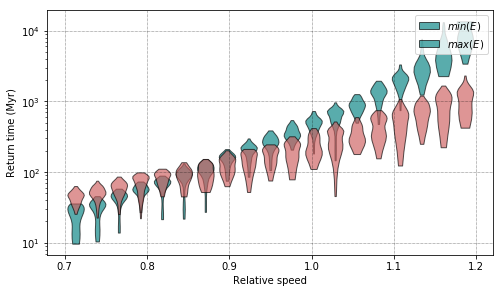

In [23]:
colors = ['#008080', '#CD5C5C']

fig, ax1 = plt.subplots(figsize = (8, 4.5))

rings, p_rings = getSpeedRings(20)

pos = [T.argmin(), T.argmax()]

for (i, p) in enumerate(pos):
    ys = subDivideData(return_times[p] * 1000, p_rings)
    parts = ax1.violinplot(ys, rings, showmeans = False, showextrema = False, widths = 0.02, points = 15)
    for pc in parts['bodies']:
        pc.set_facecolor(colors[i])
        pc.set_edgecolor('black')
        pc.set_alpha(0.65)

ax1.set_yscale('log')
        
ax1.set_xlabel('Relative speed')
ax1.set_ylabel('Return time (Myr)')

ax1.legend(['$min(E)$', '$max(E)$'])

ax1.grid()

fig.savefig('rt_speed.png', dpi = 300)
plt.show()

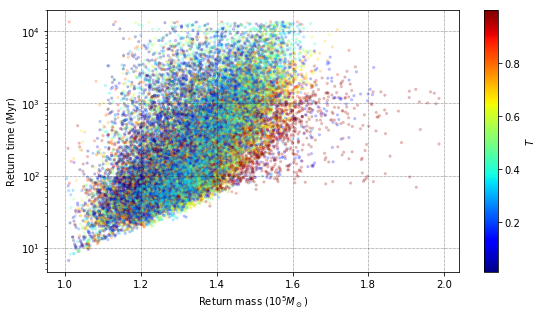

In [20]:
pos = T.argsort()
colors = smbh.rgbToHex(smbh.getColors(30))
color_m = np.zeros_like(return_times).astype(str)
for i, p in enumerate(pos):
    color_m[p, :] = colors[i]

ts = return_times.flatten() * 1000
ms = return_masses.flatten()
colors = color_m.flatten()

pos = (ms >= 1) & (ms < 2)

ts = np.log10(ts[pos])
ms = ms[pos]
colors = colors[pos]

fig, ax = plt.subplots(figsize = (8, 4.5))
ax.scatter(ms, 10 ** ts, s = 5, alpha = 0.2, color = colors)

sm = plt.cm.ScalarMappable(cmap = 'jet', norm = plt.Normalize(vmin = T.min(), vmax = T.max()))
sm._A = []
cb = fig.colorbar(sm)
cb.set_label('$T$')

ax.set_yscale('log')
ax.set_xlabel('Return mass ($10^5M_\odot$)')
ax.set_ylabel('Return time (Myr)')

ax.grid()

fig.tight_layout()

fig.savefig('correlation.png', dpi = 300)

In [21]:
cov = np.cov(ts, ms)
sigma_m = ms.std()
sigma_t = ts.std()

In [22]:
cov[0, 1] / (sigma_t * sigma_m)

0.6298709657569866